<a href="https://colab.research.google.com/github/dancher00/Experimental-Data-Analysis/blob/main/optimal_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 6**
##Development of optimal smoothing to increase the estimation accuracy


Team 1:

**- Alexey Kotcov**: overall style of report, review of code, code for first few tasks

**- Roman Khalikov**: Kalman filter code improvement, smoothing implementation, code review

**- Danil Belov**: Last task implementation with plots, code review of previous tasks

First of all we need to import our function for trajectory generation from the **previous** assignment. Additionally we will construct our future smoothing on our previous implementation of the **Kalman filter** too.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(43)

In [ ]:
def generate_trajectory(size, x_init, v_init, T, sigma_a, sigma_eta):
    # Generate true trajectory, velocity and acceleration
    x = np.zeros(size)
    V = np.zeros(size)
    # Normally distributed random acceleration with zero mathematical expectation and variance sigma_w
    a = np.random.normal(0, np.sqrt(sigma_a), size-1)
    # Normally distributed random noise with zero mathematical expectation and variance sigma_eta
    eta = np.random.normal(0, np.sqrt(sigma_eta), size)
    # Trajectory generation
    for i in range(1, size):
        V[i] = V[i-1] + a[i-1] * T
        x[i] = x[i-1] + V[i-1] * T + a[i-1] * T**2 / 2
    # Measurements generation
    z = x + eta

    return x, V, z

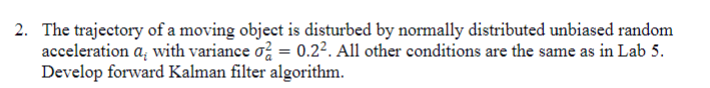

In [ ]:
# Initial conditions
x0 = 5
V0 = 1
T = 1
size_of_trajectory = 200
# Acceleration noise variance
sigma_a = 0.2**2

# Measurement noise variance
sigma_eta = 20**2


# Initial conditions
X0 = np.array([2, 0]) # initial filtered estimate
P0 = np.array([[10000, 0], # Initial filtration error covariance matrix
                 [0, 10000]])

# Transition matrix
Fi = np.array([[1, T],
              [0, 1]])

# Input matrix showing how random acceleration affects state vector
G = np.array([[T**2/2, T]]).T

# Observation matrix
H = np.array([[1.0, 0.0]])

# covariance matrix of state noise
Q = G @ G.T * sigma_a

# covariance matrix of measurements noise
R = sigma_eta

Initial conditions except acceleration noise variance are **the same**. Sigma a (acceleration variance) will be **0.2^2.**

In [ ]:
def Kalman(Fi, Q, H, R, X0, P0, z, m = 0, K_steady=None):
    size_of_trajectory = len(z)
    X = np.zeros((size_of_trajectory, 2))
    X[0] = X0

    errorx_k = np.zeros(size_of_trajectory)
    errorv_k = np.zeros(size_of_trajectory)

    if m>0:
        X_extr = np.zeros((2, size_of_trajectory))
    P = P0
    if K_steady is None:
        K = np.zeros((2,))
    else:
        K = K_steady
    K_list = np.zeros((size_of_trajectory,2))
    P_pred_list = np.zeros((size_of_trajectory,2,2))
    P_filt_list = np.zeros((size_of_trajectory,2,2))
    K_list[0] = K

    for i in range(1, size_of_trajectory):
        # Prediction (extrapolation)
        X[i] = Fi @ X[i-1]
        if (m > 0):
          Fi_extr = Fi.copy()
          for _ in range(m-2):
            Fi_extr = Fi @ Fi_extr
          X_extr[:,i] = Fi_extr @ X[i-1]
        P = Fi @ P @ Fi.T + Q
        P_pred_list[i] = P
        # Filtration
        if K_steady is None:
            K = P @ H.T * (H @ P @ H.T + R)**(-1)
        P = (np.eye(2) - K @ H) @ P
        X[i] = X[i] + (K * (z[i] - H @ X[i])).T

        P_filt_list[i] = P
        K_list[i] = K.flatten()

    if m>0:
        return X, K_list, P_pred_list, P_filt_list, X_extr
    else:
        return X, K_list, P_pred_list, P_filt_list

Of course for this task some modifications needed: for implementation of a **forward backward smoothing** of Kalman estimations we need an **updated state covariance matrix P**, so after some modifications our function returns P as well.

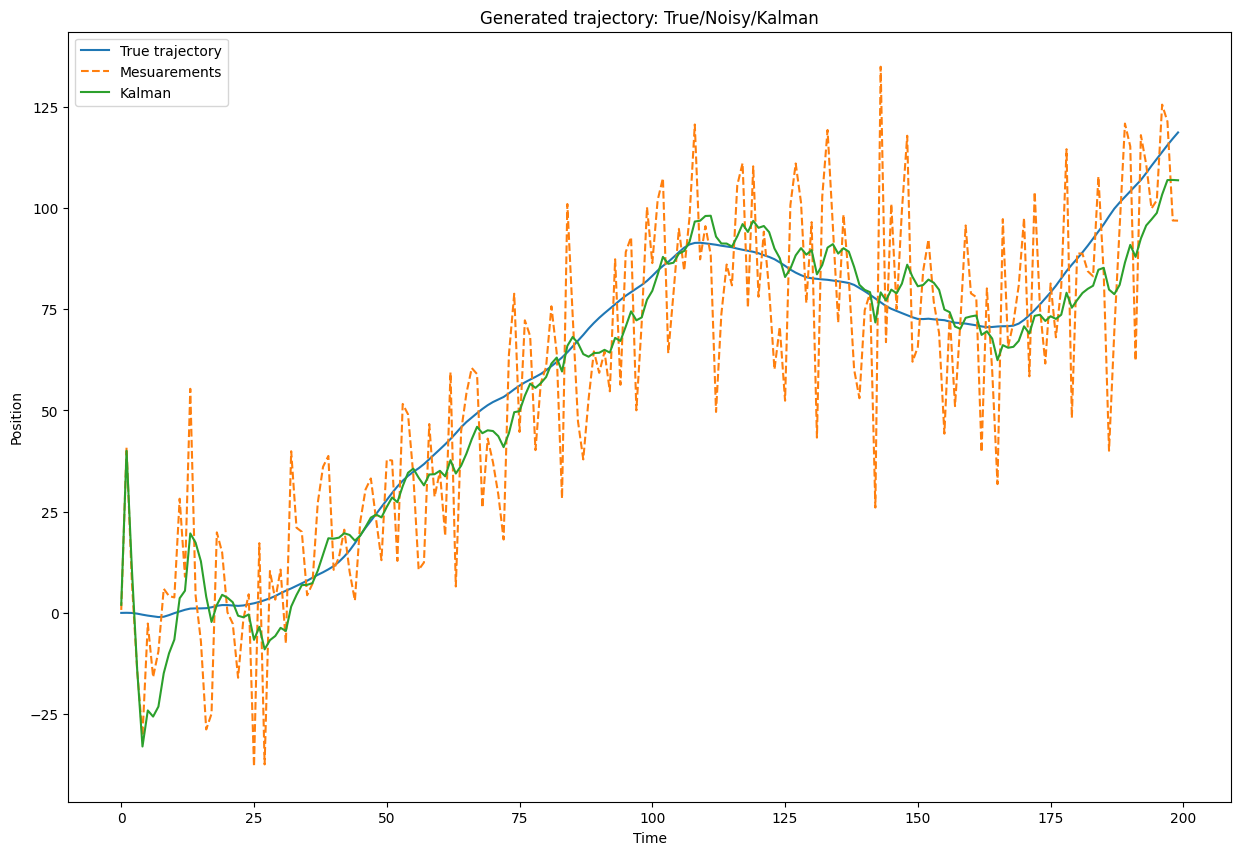

In [ ]:
x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
X_k, gain, P_pred_k, P_filt_k = Kalman(Fi, Q, H, R, X0, P0, z)
plt.figure(figsize=(15,10))
plt.plot(x, label = 'True trajectory')
plt.plot(z, label = 'Mesuarements', linestyle='dashed')
plt.plot(X_k[:,0], label = 'Kalman')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title(f'Generated trajectory: True/Noisy/Kalman')
plt.legend()

As we can see from the plot, our Kalman filter is still **working** and our modifications **have not broken the code**.

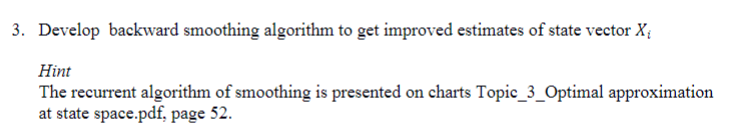

In [ ]:

# Function for backward smoothing
def kalman_smoothing(X, P_pred, P_filt, Fi):

  n = X.shape[0]
  x_dim = X.shape[1]
  X_backward = X[::-1]

  P_pred_backward = P_pred[::-1]
  P_filt_backward = P_filt[::-1]

  X_smooth = X[::-1].copy()
  P_smooth = P_filt_backward.copy()

  for i in range(1,n):
    A = P_filt_backward[i] @ Fi.T @ np.linalg.inv(P_pred_backward[i-1])
    P_smooth[i] = P_filt_backward[i] + A @ (P_smooth[i-1]-P_pred_backward[i-1]) @ A.T
    X_smooth[i] = X_backward[i] + A @ (X_smooth[i-1] - Fi @ X_backward[i])

  return X_smooth[::-1], P_smooth[::-1]

In [ ]:
x_smoothed, p_smoothed = kalman_smoothing(X_k, P_pred_k, P_filt_k, Fi)

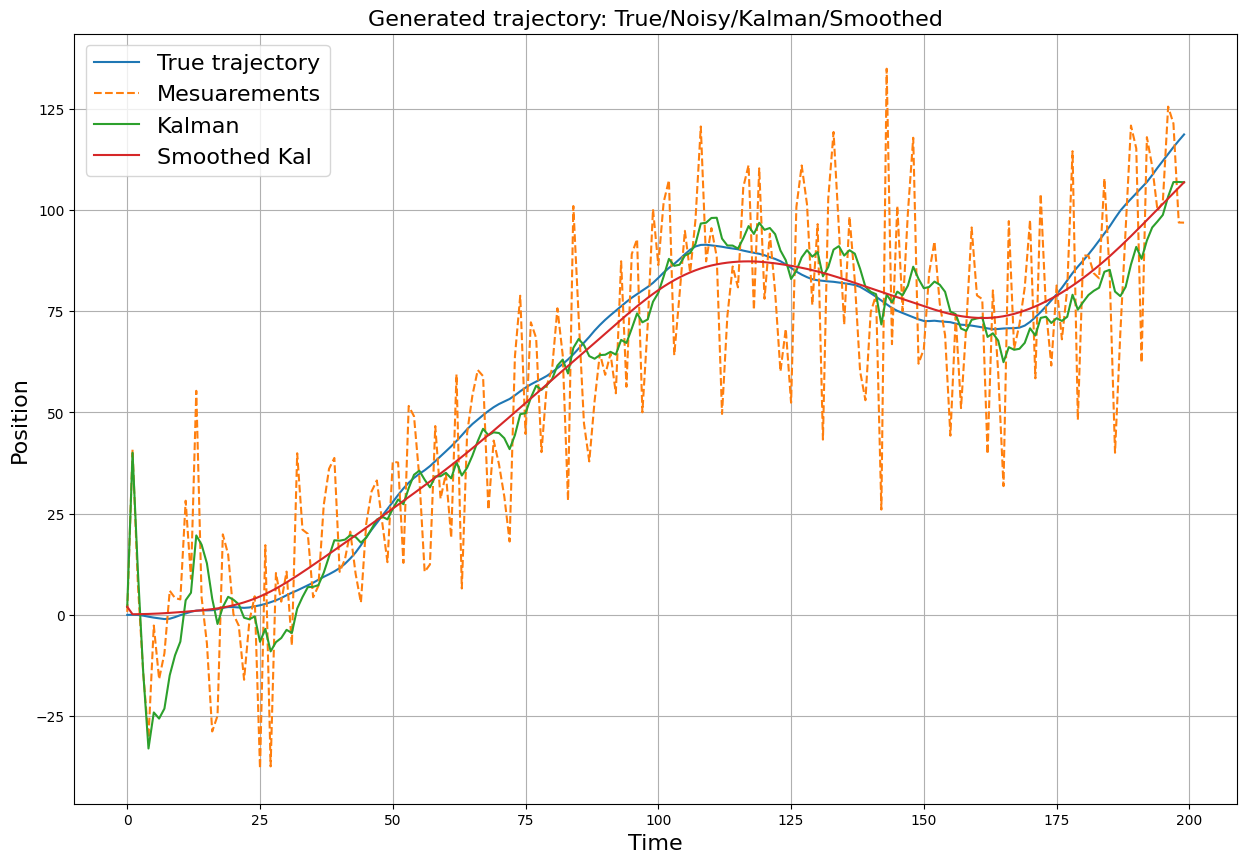

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(x, label = 'True trajectory')
plt.plot(z, label = 'Mesuarements' , linestyle='dashed')
plt.plot(X_k[:, 0], label = 'Kalman')
plt.plot(x_smoothed[:, 0], label = 'Smoothed Kal')
plt.xlabel('Time',fontsize=16)
plt.grid()
plt.ylabel('Position',fontsize=16)
plt.title(f'Generated trajectory: True/Noisy/Kalman/Smoothed',fontsize=16)
plt.legend(fontsize=16)

To be honest results are quite suprising, forward backward smoothed Kalman estimations are **almost repeats** our true trajectory. That is real result, looking at the noised measurements we can hardly tell where is true trajectory, **but our algorithm does**.

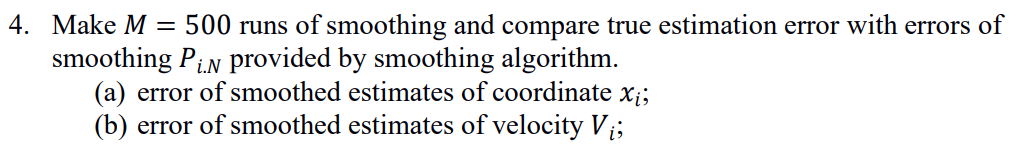

In [ ]:
np.random.seed(23)
M = 500

final_error_list = []

for i in range(M):

    x, V, z = generate_trajectory(size_of_trajectory, x0, V0, T, sigma_a, sigma_eta)
    X_true = np.swapaxes(np.array([x,V]), 0, 1)

    X_k, gain, P_pred_k, P_filt_k = Kalman(Fi, Q, H, R, X0, P0, z)
    x_smoothed, p_smoothed = kalman_smoothing(X_k, P_pred_k, P_filt_k, Fi)

    final_error_list.append((x_smoothed[3:]-X_true[3:])**2)

final_error = np.sqrt(sum(final_error_list)/(M-1))

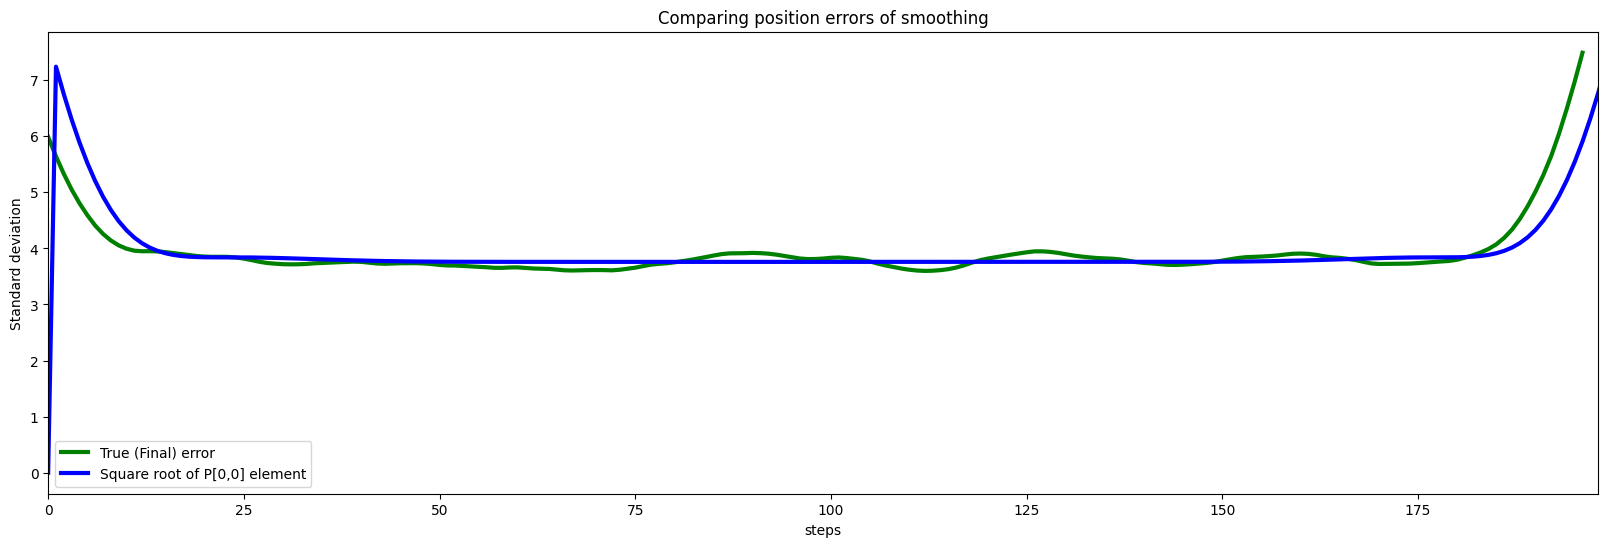

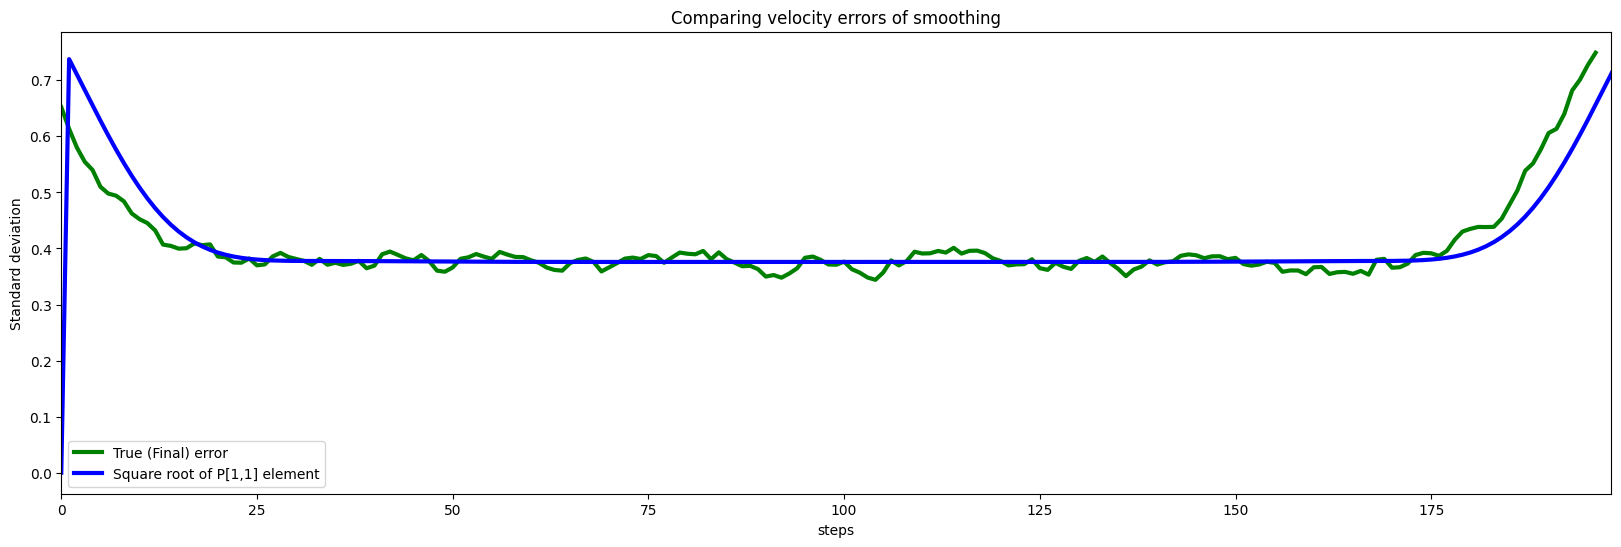

In [ ]:
fig, ax41 = plt.subplots(figsize=(20, 6))
ax41.plot(final_error[:,0], color='green', label='True (Final) error', linewidth = 3)
ax41.plot(np.sqrt(p_smoothed[:,0,0]), color='blue', label='Square root of P[0,0] element', linewidth = 3)
plt.xlabel('steps')
plt.ylabel('Standard deviation')
plt.title('Comparing position errors of smoothing')
ax41.legend()
plt.xlim([0, size_of_trajectory-2])
plt.show()

fig, ax42 = plt.subplots(figsize=(20, 6))
ax42.plot(final_error[:,1], color='green', label='True (Final) error', linewidth = 3)
ax42.plot(np.sqrt(p_smoothed[:,1,1]), color='blue', label='Square root of P[1,1] element', linewidth = 3)
plt.xlabel('steps')
plt.ylabel('Standard deviation')
plt.title('Comparing velocity errors of smoothing')
ax42.legend()
plt.xlim([0, size_of_trajectory-2])
plt.show()

This way of  checking of algorithm effectiveness was a bit unclear for us. But after some exploration and diving into lecture slides we understood **the mechanism.** Dynamics of the square root of state covariance matrix element shows us how the the covariance matrix P provides a **estimate of the true uncertainties after smoothing**. And **closer** these two plots to each other - **more effective** our smoothing algorithm provides our estimation data.

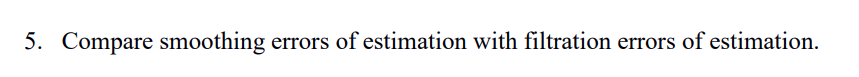

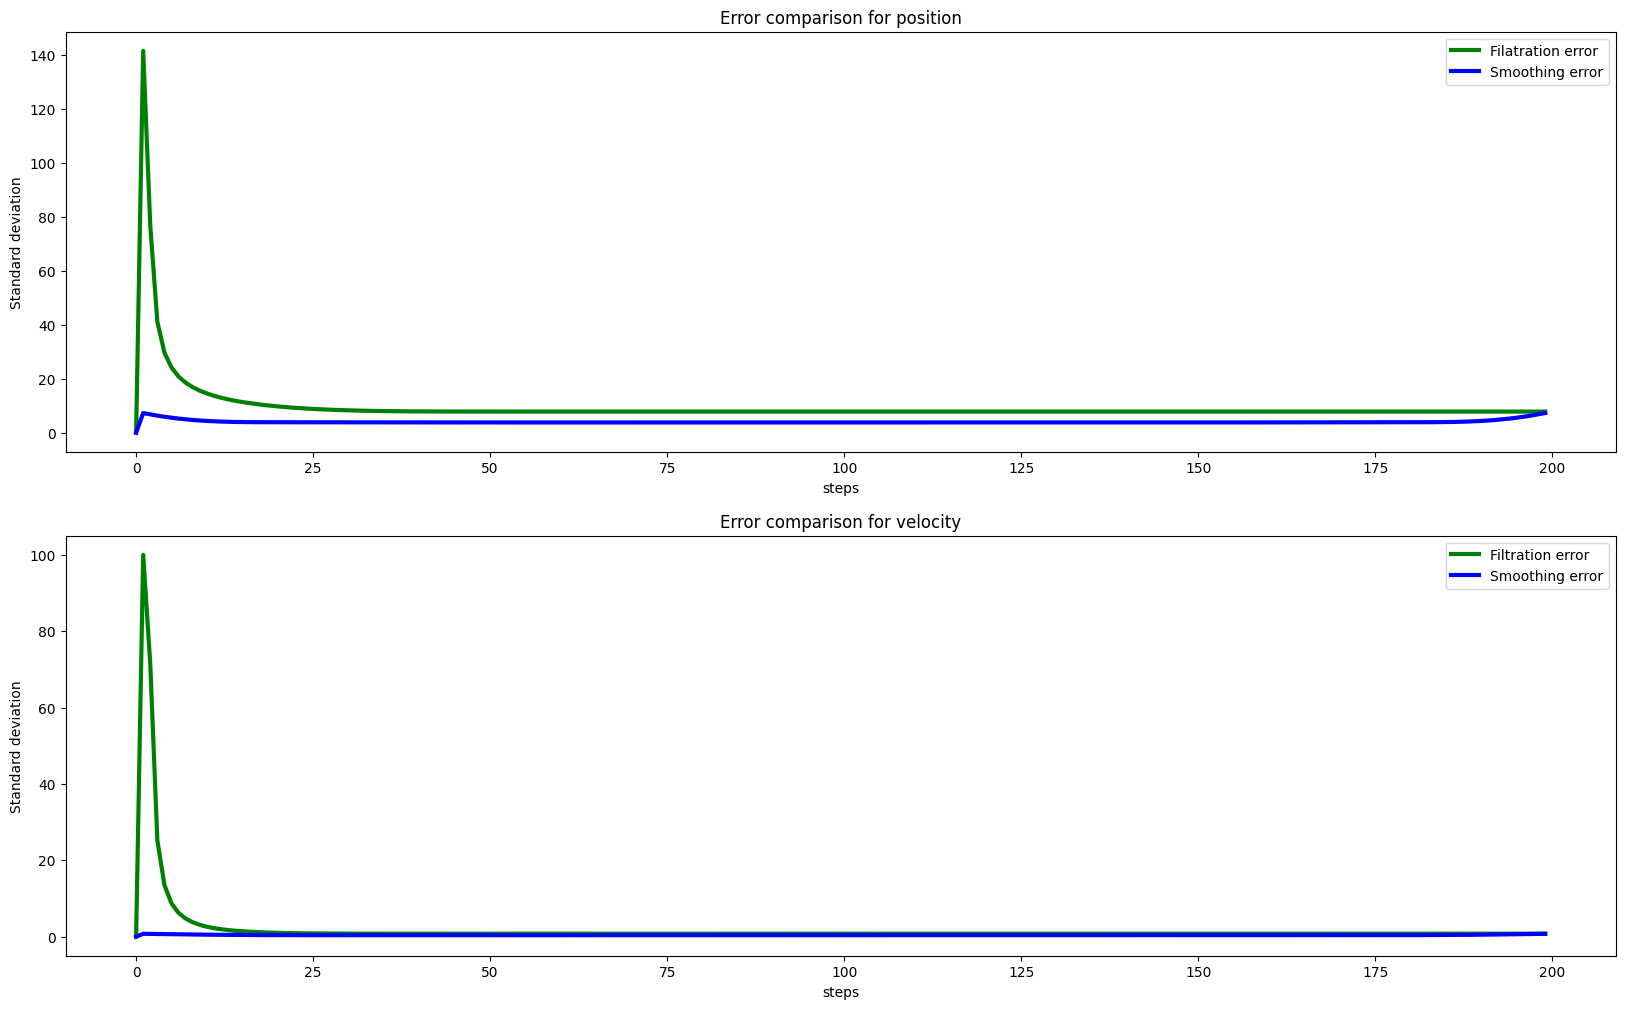

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(211)
plt.title('Error comparison for position')
plt.plot(np.sqrt(P_pred_k[:,0,0]), color='green', label='Filatration error', linewidth = 3)
plt.plot(np.sqrt(p_smoothed[:,0,0]), color='blue', label='Smoothing error', linewidth = 3)
plt.xlabel('steps')
plt.ylabel('Standard deviation')
plt.legend()

plt.subplot(212)
plt.title('Error comparison for velocity')
plt.plot(np.sqrt(P_pred_k[:,1,1]), color='green', label='Filtration error', linewidth = 3)
plt.plot(np.sqrt(p_smoothed[:,1,1]), color='blue', label='Smoothing error', linewidth = 3)
plt.xlabel('steps')
plt.ylabel('Standard deviation')
plt.legend()

The smoothing estimation error for the position looks better than the filtration estimation error as expected. The same goes for the velocity expect that both errors goes to zero.

**Conclusions**: during this assignment we were able to program a backward smoothing algorithm which employ updating every time coeffitient A based on covariation matrix of state vector for every possible step. It showed great results in this example. Additionally we improved our code for Kalman filter, in comparison with assignment 5 it is slightly more understandable thanks to some fixes of arrays shape and also we added some functions like state covariation matrix log.